# Project Notebook
Authors:
* Brocco Mattia
* Tellez Brenda

In [1]:
from google.colab import drive
drive.mount("/content/drive")

%cd /content/drive/MyDrive/Environmental-sounds-UNIPD-2022

Mounted at /content/drive
/content/drive/MyDrive/Environmental-sounds-UNIPD-2022


In [2]:
import os
import sys
import torch
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from scipy.io import wavfile
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import evaluation
import CNN_support as cnns
from gng import GrowingNeuralGas

%load_ext autoreload
%autoreload 2

In [3]:
data = pd.read_csv('./data/meta/esc50.csv')
data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


## 1. CNN for audio classification

##### SOURCES
[1] [CNN for audio (MEDIUM)](https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab)  
[2] [Types of DCT](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.dct.html#scipy.fftpack.dct)

Default sampling rate of `librosa` is 22050, while for `scipy` is 44100. This implies that we have half of the length of the sequence with the former library (110250 against 220500).  

## Preprocessing

In [4]:
# DATA AUGMENTATION

#np.random.seed(42)
#indexed_samples = np.random.choice(X.shape[0], size = 10000, replace = True)
np.random.seed(101)
randn_seeds = np.random.choice(len(data), size = len(data), replace = False)

aug_iterations = 7

new_X = []
#new_X2 = []
new_y = np.zeros(shape = (aug_iterations*len(randn_seeds), 1))

input_length = 220500
row_count = 0
for i in data.index:

    sample, sr_sample = librosa.load("./data/audio/{}".format(data.loc[i, "filename"]),
                                     sr = 44100)
    # Min-max scaler [0, 1]
    sample = (sample - sample.min()) / (sample.max() - sample.min())

    if len(sample) > input_length:
        sample = sample[:input_length]
    else:
        sample = np.pad(sample, (0, max(0, input_length - len(sample))), "constant")

    for n in range(aug_iterations):
        
        if n == 0:
            # NOISE INJECTION
            np.random.seed(randn_seeds[i])
            noise = np.random.randn(len( sample ))
            augmented_data = (sample + 0.005 * noise)

        elif n == 1:
            # TIME SHIFT: right shift
            augmented_data = np.roll(sample, 22050)

        elif n == 2:
            # PITCH SHIFT: shift down by 3
            augmented_data = librosa.effects.pitch_shift(y = sample, sr = sr_sample,
                                                         n_steps = 3)
        elif n == 3:
            # PITCH SHIFT: shift down by -3
            augmented_data = librosa.effects.pitch_shift(y = sample, sr = sr_sample,
                                                         n_steps = -3)
        elif n == 4:
            # SPEED SHIFT: faster
            augmented_data = librosa.effects.time_stretch(y = sample, rate = 1.25)
            augmented_data = np.append(augmented_data,
                                       np.zeros(shape = len(sample) - len(augmented_data)))
        elif n == 5:
            # SPEED SHIFT: slower (returns longer array)
            augmented_data = librosa.effects.time_stretch(y = sample, rate = 0.8)
            augmented_data = augmented_data[:len(sample)]

        else:
            # KEEP NORMAL SAMPLE
            augmented_data = sample

        #new_instance = librosa.feature.mfcc(y = augmented_data, sr = sr_sample,
        #                                    hop_length = 512, n_mfcc = 60)
        
        new_MFCC = librosa.feature.mfcc(y = augmented_data, sr = sr_sample,
                                        hop_length = 512, n_mfcc = 60)
        new_chromagram = librosa.feature.chroma_stft(y = augmented_data, sr = sr_sample,
                                                     hop_length = 512, win_length = 1024,
                                                     n_chroma = 60)
        new_delta = librosa.feature.delta(new_MFCC)
    
        new_instance = np.dstack((new_MFCC, new_chromagram, new_delta))

    
        new_X += [new_instance]
        #new_X2 += [new_instance2]
        new_y[row_count] = data.loc[i, "target"]
        
        row_count += 1
        
    
new_X = np.array(new_X)
new_X = new_X.astype(np.float32)

/usr/local/lib/python3.8/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
/usr/local/lib/python3.8/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, train_size = .8,
                                                    random_state = 42, shuffle = True)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, train_size = .5,
                                                    random_state = 42, shuffle = True)

print("Training examples: {}".format(y_train.shape[0]))
print("Validation examples: {}".format(y_valid.shape[0]))
print("Test examples: {}".format(y_test.shape[0]))
print()
print("Input shape: {}".format(X_train[0].shape))

Training examples: 11200
Validation examples: 1400
Test examples: 1400

Input shape: (60, 431, 3)


In [ ]:
dataframe1 = pd.DataFrame(X_train.reshape(len(X_train), -1))
dataframe1.columns = [str(i) for i in range(dataframe1.shape[1])]
dataframe1.to_parquet(".//data/X_train_CNN_60x431x3_7times.parquet")

dataframe2 = pd.DataFrame(X_valid.reshape(len(X_valid), -1))
dataframe2.columns = [str(i) for i in range(dataframe2.shape[1])]
dataframe2.to_parquet(".//data/X_valid_CNN_60x431x3_7times.parquet")

dataframe3 = pd.DataFrame(X_test.reshape(len(X_test), -1))
dataframe3.columns = [str(i) for i in range(dataframe3.shape[1])]
dataframe3.to_parquet(".//data/X_test_CNN_60x431x3_7times.parquet")

dataframe4 = pd.DataFrame(np.vstack([y_train, y_valid, y_test]))
dataframe4.columns = ["0"]
dataframe4.to_parquet(".//data/y_CNN_7times.parquet")

## Algo tries

In [5]:
BATCH_SIZE1 = 100

In [4]:
X_train = pd.read_parquet(".//data/X_train_CNN_60x431x3_7times.parquet")
X_valid = pd.read_parquet(".//data/X_valid_CNN_60x431x3_7times.parquet")
X_test = pd.read_parquet(".//data/X_test_CNN_60x431x3_7times.parquet")
y = pd.read_parquet(".//data/y_CNN_7times.parquet")
y["0"] = y["0"].astype(int)

X_train = X_train.values.reshape(len(X_train), 60, 431, 3)
X_valid = X_valid.values.reshape(len(X_valid), 60, 431, 3)
X_test = X_test.values.reshape(len(X_test), 60, 431, 3)

y_train = y.values[:len(X_train)]
y_valid = y.values[len(X_train):len(X_train) + len(X_valid)]
y_test = y.values[len(X_train) + len(X_valid):]

In [6]:
# Identify and select the TPU
try:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])

  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)  # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.TPUStrategy(tpu)
except:
  pass

In [7]:
with tpu_strategy.scope():
  # creating the model in the TPUStrategy
  # scope means we will train the model on the TPU
  model0 =  keras.models.Sequential([keras.layers.Conv2D(filters = 30, kernel_size = [12, 6],
                                                          padding = "same", activation = "relu",
                                                          input_shape = [60, 431, 3]),
                                      keras.layers.MaxPool2D(pool_size = (3, 3), strides = (1, 3)),
                                      keras.layers.Dropout(rate = .5),
                                      keras.layers.Conv2D(filters = 30, kernel_size = (1, 3),
                                                          padding = "same", activation = "relu"),
                                      keras.layers.MaxPool2D(pool_size = (1, 3), strides = (1, 3)), # DON'T TOUCH THIS LAYER
                                      keras.layers.Conv2D(filters = 10, kernel_size = (1, 3),
                                                          padding = "same", activation = "relu"),
                                      keras.layers.MaxPool2D(pool_size = (1, 3), strides = (1, 3)),
                                      keras.layers.Flatten(),
                                      keras.layers.Dense(500, activation = "relu"), # BOOSTS PERFORMANCE
                                      keras.layers.Dropout(rate = .5),
                                      keras.layers.Dense(50, activation = "softmax") ],
                                    name = "M0")

  model0.compile(loss = "sparse_categorical_crossentropy",
                  metrics = ["accuracy"],
                  optimizer = keras.optimizers.Adam(learning_rate = 1e-4))

print(model0.summary())

Model: "M0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 431, 30)       6510      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 58, 143, 30)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 58, 143, 30)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 143, 30)       2730      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 47, 30)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 47, 10)        910      

In [8]:
split_train = []
for j in tqdm(range(4)):
  j_start = int(j*(len(X_train)/4))
  j_stop = int((j+1)*(len(X_train)/4))
  hist_j = model0.fit(X_train[j_start:j_stop], y_train[j_start:j_stop],
                      epochs = 200, batch_size = BATCH_SIZE1,
                      validation_data = (X_valid, y_valid),
                      verbose = 0,
                      callbacks = [keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                                                 patience = 20)])
  
  split_train.append(hist_j.history)

100%|██████████| 4/4 [17:11<00:00, 257.80s/it]



44/44 - 1s - loss: 0.8750 - accuracy: 0.7757 - 1s/epoch - 23ms/step
Accuracy on test: 77.57%
Memory used: 664.3 Mb


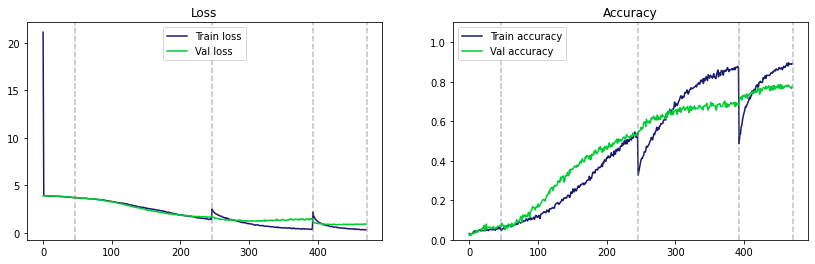

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
ax[0].plot(split_train[0]["loss"]+split_train[1]["loss"]+
           split_train[2]["loss"]+split_train[3]["loss"],
           label = "Train loss", color = "#191970")
ax[0].plot(split_train[0]["val_loss"]+split_train[1]["val_loss"]+
           split_train[2]["val_loss"]+split_train[3]["val_loss"],
           label = "Val loss", color = "#00CC33")
ax[0].set_title("Loss")
ax[0].legend()

ax[1].plot(split_train[0]["accuracy"]+split_train[1]["accuracy"]+
           split_train[2]["accuracy"]+split_train[3]["accuracy"],
           label = "Train accuracy", color = "#191970")
ax[1].plot(split_train[0]["val_accuracy"]+split_train[1]["val_accuracy"]+
           split_train[2]["val_accuracy"]+split_train[3]["val_accuracy"],
           label = "Val accuracy", color = "#00CC33")
ax[1].set_title("Accuracy")
ax[1].set_ylim(0, 1.1)
ax[1].legend()

for i in range(len(ax)):
    step_n = 0
    for el in split_train:
        step_n += len(el["val_loss"])
        ax[i].axvline(step_n, ls = "--", color = "grey", alpha = .5)

print()
scores0 = model0.evaluate(X_test, y_test, verbose = 2)
print("="*71)
print("Accuracy on test: {:.2f}%".format(scores0[1]*100))
print("Memory used: {:.1f} Mb".format(
        evaluation.keras_model_memory_usage_in_bytes(model = model0,
                                                     batch_size = BATCH_SIZE1)/1e6))

plt.show()
#plt.savefig("CNN-only.jpg", dpi = 300)

In [18]:
print(classification_report(y_test, model0.predict(X_test).argmax(axis = 1)))

44/44 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        35
           1       0.91      0.89      0.90        35
           2       0.71      0.82      0.76        33
           3       0.87      0.76      0.81        34
           4       0.90      0.90      0.90        29
           5       0.68      0.87      0.76        30
           6       0.81      0.62      0.70        34
           7       0.75      0.72      0.73        25
           8       0.84      0.75      0.79        28
           9       0.84      0.95      0.89        22
          10       0.62      0.88      0.72        24
          11       0.72      0.72      0.72        25
          12       0.92      0.73      0.81        30
          13       0.94      0.84      0.89        19
          14       0.76      0.90      0.82        31
          15       0.79      0.53      0.63        36
          16       0.74    

### Input with only two channels

In [21]:
X_train2 = X_train[:, :, :, :-1]
X_valid2 = X_valid[:, :, :, :-1]
X_test2 = X_test[:, :, :, :-1]

In [23]:
with tpu_strategy.scope():
  # creating the model in the TPUStrategy
  # scope means we will train the model on the TPU
  model2 =  keras.models.Sequential([keras.layers.Conv2D(filters = 30, kernel_size = [12, 6],
                                                          padding = "same", activation = "relu",
                                                          input_shape = [60, 431, 2]),
                                      keras.layers.MaxPool2D(pool_size = (3, 3), strides = (1, 3)),
                                      keras.layers.Dropout(rate = .5),
                                      keras.layers.Conv2D(filters = 30, kernel_size = (1, 3),
                                                          padding = "same", activation = "relu"),
                                      keras.layers.MaxPool2D(pool_size = (1, 3), strides = (1, 3)), # DON'T TOUCH THIS LAYER
                                      keras.layers.Conv2D(filters = 10, kernel_size = (1, 3),
                                                          padding = "same", activation = "relu"),
                                      keras.layers.MaxPool2D(pool_size = (1, 3), strides = (1, 3)),
                                      keras.layers.Flatten(),
                                      keras.layers.Dense(500, activation = "relu"), # BOOSTS PERFORMANCE
                                      keras.layers.Dropout(rate = .5),
                                      keras.layers.Dense(50, activation = "softmax") ],
                                    name = "M2")

  model2.compile(loss = "sparse_categorical_crossentropy",
                  metrics = ["accuracy"],
                  optimizer = keras.optimizers.Adam(learning_rate = 1e-4))

print(model0.summary())

Model: "M0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 431, 30)       6510      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 58, 143, 30)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 58, 143, 30)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 143, 30)       2730      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 47, 30)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 47, 10)        910      

In [24]:
split_train2 = []
for j in tqdm(range(4)):
  j_start = int(j*(len(X_train2)/4))
  j_stop = int((j+1)*(len(X_train2)/4))
  hist_j = model2.fit(X_train2[j_start:j_stop], y_train[j_start:j_stop],
                      epochs = 200, batch_size = BATCH_SIZE1,
                      validation_data = (X_valid2, y_valid),
                      verbose = 0,
                      callbacks = [keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                                                 patience = 20)])
  
  split_train2.append(hist_j.history)

100%|██████████| 4/4 [13:33<00:00, 203.37s/it]



44/44 - 10s - loss: 0.6215 - accuracy: 0.8664 - 10s/epoch - 232ms/step
Accuracy on test: 86.64%
Memory used: 664.3 Mb


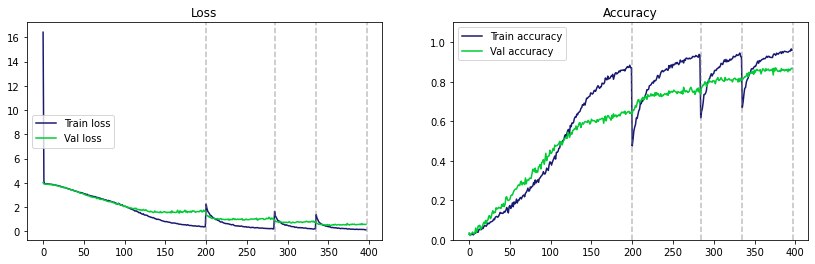

In [25]:
fig2, ax2 = plt.subplots(1, 2, figsize = (14, 4))
ax2[0].plot(split_train2[0]["loss"]+split_train2[1]["loss"]+
            split_train2[2]["loss"]+split_train2[3]["loss"],
            label = "Train loss", color = "#191970")
ax2[0].plot(split_train2[0]["val_loss"]+split_train2[1]["val_loss"]+
            split_train2[2]["val_loss"]+split_train2[3]["val_loss"],
            label = "Val loss", color = "#00CC33")
ax2[0].set_title("Loss")
ax2[0].legend()

ax2[1].plot(split_train2[0]["accuracy"]+split_train2[1]["accuracy"]+
            split_train2[2]["accuracy"]+split_train2[3]["accuracy"],
            label = "Train accuracy", color = "#191970")
ax2[1].plot(split_train2[0]["val_accuracy"]+split_train2[1]["val_accuracy"]+
            split_train2[2]["val_accuracy"]+split_train2[3]["val_accuracy"],
            label = "Val accuracy", color = "#00CC33")
ax2[1].set_title("Accuracy")
ax2[1].set_ylim(0, 1.1)
ax2[1].legend()

for i in range(len(ax2)):
    step_n = 0
    for el in split_train2:
        step_n += len(el["val_loss"])
        ax2[i].axvline(step_n, ls = "--", color = "grey", alpha = .5)

print()
scores2 = model2.evaluate(X_test2, y_test, verbose = 2)
print("="*71)
print("Accuracy on test: {:.2f}%".format(scores2[1]*100))
print("Memory used: {:.1f} Mb".format(
        evaluation.keras_model_memory_usage_in_bytes(model = model2,
                                                     batch_size = BATCH_SIZE1)/1e6))

plt.show()
#plt.savefig("CNN-only.jpg", dpi = 300)

---
---
---